### Implementation details for contunuous action spaces
1. Continuous actions via normal distributions

    Policy gradient methods assume the continuous actions are sampled from a normal distribution. So to create such distribution, the neural network needs to output the mean and standard deviation of the continuous action.Gaussian is very popular distribution to represent the action distribution.

2. State-independent log standard deviation

    The implementation outputs the logits for the mean, but instead of outputting the logits for the standard deviation, it outputs the logarithm of the standard deviation. In addition, this log std is set to be state-independent and initialized to be 0.

3. Independent action components

    In many robotics tasks, it is common to have multiple scalar values to represent a continuous action. PPO treats actions at time step [a1, a2] as probabilistically independent action components, therefore calculating prob(a)=prob(a1)⋅prob(a2)

4. Preprocessing wrappers:
    *   Action clipping to valid range and storage
    *   Normalization of Observation
    *   Observation Clipping
    *   Normalization of Rewards
    *   Reward Clipping




In [1]:
!pip install --upgrade gym==0.24.0
!pip install pybullet

In [ ]:
import argparse
import random
import gym
import numpy as np
import pybullet_envs

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

In [ ]:
def make_env(env_id, seed, idx, record_video=False):
    def thunk():
        env = gym.make(env_id)
        if record_video and idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{env_id}")

        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)

        # Preprocessing wraps
        env = gym.wrappers.ClipAction(env)
        env = gym.wrappers.NormalizeObservation(env)
        env = gym.wrappers.TransformObservation(env, lambda obs: np.clip(obs, -10, 10))
        env = gym.wrappers.NormalizeReward(env)
        env = gym.wrappers.TransformReward(env, lambda reward: np.clip(reward, -10, 10))

        return env

    return thunk

In [3]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    nn.init.orthogonal_(layer.weight, std)
    nn.init.constant_(layer.bias, bias_const)
    return layer

In [4]:
class PPOAgent(nn.Module):
    def __init__(self, envs):
        super(PPOAgent, self).__init__()

        total_obs_elements = np.prod(envs.single_observation_space.shape)
        total_action_elements = np.prod(envs.single_action_space.shape)

        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(total_obs_elements, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, total_action_elements), std=0.01)
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, total_action_elements))

        self.critic = nn.Sequential(
            layer_init(nn.Linear(total_obs_elements, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0)
        )


    def get_value(self, x):
        return self.critic(x)


    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean) # Expand with the num of envs
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)

        if action is None:
            action = probs.sample()

        log_prob = probs.log_prob(action).sum(dim=1)
        entropy = probs.entropy().sum(dim=1)
        value = self.critic(x)

        return action, log_prob, entropy, value

In [5]:
config = argparse.Namespace()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.seed = 1

config.env_id = 'HalfCheetahBulletEnv-v0'
config.num_envs = 1
config.num_steps = 2048     # The number of steps to run in each env to policy rollout

config.batch_size = config.num_envs * config.num_steps
config.num_minibatches = 32 # the number of mini-batches
config.minibatch_size = config.batch_size // config.num_minibatches

config.total_timesteps = 2000000
config.num_updates = config.total_timesteps // config.batch_size
config.num_epochs = 10

config.learning_rate = 3e-4
config.gamma = 0.99
config.anneal_lr = True    # Learning rate annealing for policy and value networks
config.gae = True         # Generalized Advantage Estimation
config.gae_lambda = 0.95

config.norm_adv = True     # Advantages normalization
config.clip_coef = 0.2     # The surrogate clipping coefficient (policy and value function)
config.clip_vloss = True   # Use clip_coef to clip value function

config.vf_coef = 0.5       # The value coefficient to calculate loss
config.ent_coef = 0.0     # Encourages the policy to explore a diverse set of actions
config.max_grad_norm = 0.5 # The maximum normalization for the gradient clipping
config.target_kl = None   # The target KL divergence threshold

config.track = False

Connect to Weights and Biases

In [ ]:
if config.track:
    !pip install wandb

In [ ]:
if config.track:
    import wandb
    wandb.login()

/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
if config.track:
    wandb.init(
        project='ppo-implementation-details',
        config=config,
        name=config.env_id,
        monitor_gym=True,
        save_code=True,
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
wandb: Currently logged in as: jupit. Use `wandb login --relogin` to force relogin


In [6]:
# Seeding
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

envs = gym.vector.SyncVectorEnv(
    [make_env(config.env_id, config.seed + i, i, record_video=True) for i in range(config.num_envs)]
)

print("Observation space:", envs.single_observation_space)
print("Action space:", envs.single_action_space)

assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

agent = PPOAgent(envs).to(config.device)
optimizer = optim.Adam(agent.parameters(), lr=config.learning_rate, eps=1e-5)

Observation space: Box(-inf, inf, (26,), float32)
Action space: Box(-1.0, 1.0, (6,), float32)


/usr/local/lib/python3.10/dist-packages/gym/utils/env_checker.py:144: UserWarning: WARN: Agent's minimum observation space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/env_checker.py:148: UserWarning: WARN: Agent's maxmimum observation space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:619: UserWarning: WARN: Env check failed with the following message: The environment cannot be reset with a random seed, even though `seed` or `kwargs` appear in the signature. This should never happen, please report this issue. The error was: WalkerBaseBulletEnv.reset() got an unexpected keyword argument 'seed'
You can set `disable_env_checker=True` to disable this check.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /content/videos/HalfCheetahBulletEnv-v0 folder (try s

In [7]:
def compute_gae_advantages(rewards, values, next_return, dones, num_steps, gamma=0.99, gae_lambda=0.95):
    gae_advantages = torch.zeros_like(rewards)

    gae = 0
    for t in reversed(range(num_steps)):
        delta = rewards[t] + gamma * next_return * (1 - dones[t]) - values[t]
        gae = delta + gamma * gae_lambda * gae * (1 - dones[t])
        gae_advantages[t] = gae
        next_return = values[t]

    returns = gae_advantages + values
    return returns, gae_advantages

In [8]:
def compute_n_step_return(rewards, values, next_return, dones, num_steps, gamma=0.99):
      returns = torch.zeros_like(rewards)

      for t in reversed(range(num_steps)):
          returns[t] = rewards[t] + gamma * next_return * (1 - dones[t])
          next_return = returns[t]

      advantages = returns - values
      return returns, advantages

In [9]:
def PPOTrain(envs, optimizer, config):
  global global_step

  # Storage setup
  observations = torch.zeros((config.num_steps, config.num_envs) + envs.single_observation_space.shape).to(config.device)
  actions = torch.zeros((config.num_steps, config.num_envs) + envs.single_action_space.shape).to(config.device)
  rewards = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  dones = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  values = torch.zeros((config.num_steps, config.num_envs)).to(config.device)
  logprobs = torch.zeros((config.num_steps, config.num_envs)).to(config.device)

  for update in range(config.num_updates):
      # Update learning rate
      if config.anneal_lr:
          lr_frac = 1.0 - update / config.num_updates
          optimizer.param_groups[0]["lr"] = lr_frac * config.learning_rate

      # Do n-steps
      episodic_return = 0
      obs = envs.reset()
      for step in range(config.num_steps):
          global_step += config.num_envs

          with torch.no_grad():
              obs_tensor = torch.Tensor(obs).to(config.device)
              action, logprob, _, value = agent.get_action_and_value(obs_tensor)

          next_obs, reward, done, _ = envs.step(action.cpu().numpy())

          # Save batch
          observations[step] = obs_tensor
          actions[step] = torch.Tensor(action).to(config.device)
          rewards[step] = torch.Tensor(reward).to(config.device)
          dones[step] = torch.Tensor(done).to(config.device)
          values[step] = torch.Tensor(value.flatten()).to(config.device)
          logprobs[step] = torch.Tensor(logprob).to(config.device)

          episodic_return += reward.mean()
          obs = next_obs

      print(f"global_step={global_step}, episodic_return={episodic_return}")
      if config.track:
          wandb.log({'episodic_return': episodic_return})

      # Generalized Advantage Estimation
      with torch.no_grad():
          next_obs_tensor = torch.Tensor(next_obs).to(config.device)
          next_value = agent.get_value(next_obs_tensor).reshape(1, -1)

          if config.gae:
              returns, advantages = compute_gae_advantages(rewards, values, next_value, dones, config.num_steps, config.gamma, config.gae_lambda)
          else:
              returns, advantages = compute_n_step_return(rewards, values, next_value, dones, config.num_steps, config.gamma)

      # Flatten the batch: num_steps * num_envs
      b_observations = observations.reshape((-1,) + envs.single_observation_space.shape)
      b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
      b_returns = returns.reshape(-1)
      b_values = values.reshape(-1)
      b_logprobs = logprobs.reshape(-1)
      b_advantages = advantages.reshape(-1)

      clip_fracs = []

      # Shuffles the indices of the batch and breaks it into mini-batches
      batch_inds = np.arange(config.batch_size)
      for epoch in range(config.num_epochs):
          np.random.shuffle(batch_inds)

          for start in range(0, config.batch_size, config.minibatch_size):
              end = start + config.minibatch_size
              minibatch_inds = batch_inds[start:end]

              # Mini-batches: targets
              mb_observations = b_observations[minibatch_inds]
              mb_actions = b_actions[minibatch_inds]
              mb_returns = b_returns[minibatch_inds]
              mb_values = b_values[minibatch_inds]
              mb_logprobs = b_logprobs[minibatch_inds]
              mb_advantages = b_advantages[minibatch_inds]

              # Advantages normalization
              if config.norm_adv:
                  mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

              # Predictions
              _, mb_logprobs_pred, mb_entropy_pred, mb_values_pred = agent.get_action_and_value(mb_observations, mb_actions)

              log_ratio = mb_logprobs_pred - mb_logprobs
              ratio = log_ratio.exp()

              with torch.no_grad():
                  clip_fracs += [((ratio - 1.0).abs() > config.clip_coef).float().mean().item()]

              # Policy loss
              pg_loss_unclipped = -mb_advantages * ratio
              pg_loss_clipped = -mb_advantages * torch.clamp(ratio, 1 - config.clip_coef, 1 + config.clip_coef)
              pg_loss = torch.max(pg_loss_unclipped, pg_loss_clipped).mean()

              # Value loss
              mb_values_pred = mb_values_pred.view(-1)

              v_loss_sqrt = (mb_values_pred - mb_returns) ** 2 # Unclipped
              if config.clip_vloss:
                  # Ensure that the value function updates do not deviate too far from the original values
                  v_clipped = torch.clamp(mb_values_pred, mb_values - config.clip_coef, mb_values + config.clip_coef)
                  v_loss_clipped = (v_clipped - mb_returns) ** 2
                  v_loss_sqrt = torch.max(v_loss_sqrt, v_loss_clipped)

              v_loss = 0.5 * v_loss_sqrt.mean()

              # Entropy Loss
              entropy_loss = mb_entropy_pred.mean()

              # Overall Loss
              loss = pg_loss - config.ent_coef * entropy_loss + config.vf_coef * v_loss

              optimizer.zero_grad()
              loss.backward()

              # Global Gradient Clipping
              nn.utils.clip_grad_norm_(agent.parameters(), config.max_grad_norm)

              optimizer.step()

          with torch.no_grad():
            # old_approx_kl = (-logratio).mean()
            approx_kl = ((ratio - 1) - log_ratio).mean()

          # Early stop using approx_kl
          if config.target_kl is not None:
                if approx_kl > config.target_kl:
                    break

      y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
      var_y = np.var(y_true)
      explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

      if config.track:
          metrics = {
              "GLOBAL STEP": global_step,
              "loss": loss.item(),
              "learning_rate": optimizer.param_groups[0]["lr"],
              "value_loss": v_loss.item(),
              "policy_loss": pg_loss.item(),
              "entropy": entropy_loss.item(),
              "approx_kl": approx_kl.item(),
              "clip_frac": np.mean(clip_fracs),
              "explained_variance": explained_var
          }
          wandb.log(metrics)
          print(metrics)

In [10]:
global_step = 0

In [11]:
PPOTrain(envs, optimizer, config)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_re

global_step=2048, episodic_return=-85.14524733986849
global_step=4096, episodic_return=-73.37396978528992
global_step=6144, episodic_return=-79.16885067828436


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=8192, episodic_return=-74.72042395105655
global_step=10240, episodic_return=-73.58996902189486
global_step=12288, episodic_return=-65.59685910612663
global_step=14336, episodic_return=-62.31841316967354
global_step=16384, episodic_return=-69.14796757325475
global_step=18432, episodic_return=-61.63431003134879
global_step=20480, episodic_return=-63.808187893766195
global_step=22528, episodic_return=-58.090737787414604
global_step=24576, episodic_return=-52.59687076006305
global_step=26624, episodic_return=-49.9361111731289


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=28672, episodic_return=-46.83642762144003
global_step=30720, episodic_return=-49.56116564108483
global_step=32768, episodic_return=-42.157837205085514
global_step=34816, episodic_return=-39.67807746835957
global_step=36864, episodic_return=-37.5583858648602
global_step=38912, episodic_return=-35.960706287251725
global_step=40960, episodic_return=-37.50836614836245
global_step=43008, episodic_return=-28.64295462628016
global_step=45056, episodic_return=-26.83457005075961
global_step=47104, episodic_return=-23.499913189167884
global_step=49152, episodic_return=-20.13114426588086
global_step=51200, episodic_return=-13.62493855088955
global_step=53248, episodic_return=-20.731134195129254
global_step=55296, episodic_return=-37.7653891748624
global_step=57344, episodic_return=-24.67963405301434
global_step=59392, episodic_return=-1.8360034108459589
global_step=61440, episodic_return=-6.2934082676596
global_step=63488, episodic_return=-28.161546701540846


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=65536, episodic_return=-9.083499316706042
global_step=67584, episodic_return=-5.3267788397835005
global_step=69632, episodic_return=10.703035909526244
global_step=71680, episodic_return=8.679119628410307
global_step=73728, episodic_return=-2.9303802514424953
global_step=75776, episodic_return=-4.444603489345306
global_step=77824, episodic_return=14.60741780079648
global_step=79872, episodic_return=5.706545537290431
global_step=81920, episodic_return=-12.085108479922509
global_step=83968, episodic_return=14.705157360802382
global_step=86016, episodic_return=-10.059887504299358
global_step=88064, episodic_return=1.9674606941801749
global_step=90112, episodic_return=14.503685783948718
global_step=92160, episodic_return=14.301285267918376
global_step=94208, episodic_return=15.293447177713952
global_step=96256, episodic_return=14.869692757625732
global_step=98304, episodic_return=14.684850392506059
global_step=100352, episodic_return=14.772556613661822
global_step=102400, episod

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=129024, episodic_return=17.451932871545242
global_step=131072, episodic_return=14.808102911768986
global_step=133120, episodic_return=16.221668990276545
global_step=135168, episodic_return=17.388663863468068
global_step=137216, episodic_return=17.033313545014455
global_step=139264, episodic_return=17.34509918511732
global_step=141312, episodic_return=17.37990195691028
global_step=143360, episodic_return=17.457403644243563
global_step=145408, episodic_return=17.079700182780012
global_step=147456, episodic_return=17.320425032844117
global_step=149504, episodic_return=18.518849783571223
global_step=151552, episodic_return=19.118236879546842
global_step=153600, episodic_return=19.017007429876546
global_step=155648, episodic_return=2.2261886477487716
global_step=157696, episodic_return=8.721936415715295
global_step=159744, episodic_return=9.186953673553543
global_step=161792, episodic_return=14.577573582210809
global_step=163840, episodic_return=11.30260834074499
global_step=165

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:57: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:130: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(


global_step=221184, episodic_return=23.807621663302342
global_step=223232, episodic_return=25.00198993363812
global_step=225280, episodic_return=24.801628619060274
global_step=227328, episodic_return=18.470161595067207
global_step=229376, episodic_return=26.195984412094305
global_step=231424, episodic_return=14.567371342427972
global_step=233472, episodic_return=13.628540183024453
global_step=235520, episodic_return=27.87885381462771
global_step=237568, episodic_return=19.706276689883108
global_step=239616, episodic_return=27.61384666379187
global_step=241664, episodic_return=14.107286663596891
global_step=243712, episodic_return=13.676369707407162
global_step=245760, episodic_return=15.17520170923038
global_step=247808, episodic_return=29.900740825754358
global_step=249856, episodic_return=25.47849501440991
global_step=251904, episodic_return=29.13215163295991
global_step=253952, episodic_return=22.087781171786116
global_step=256000, episodic_return=27.00678954215112


KeyboardInterrupt: ignored

In [ ]:
envs.close()
if config.track: wandb.finish()

GLOBAL STEP,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
approx_kl,▃▁▅▃▅█▃▅▃▃▃▃▄▃▁▆▅▅▄▃▃▃▄▇
clip_frac,▃▁▄▄▆█▄▄▃▇▄▃▅▆▅▇▇▅▄▇▄▄██
entropy,██▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▂▁▁▁▁
episodic_return,▁▂▂▃▃▃▅▄▄▄▅▆▆▆▆▆▆▇▆▇██▇▇
explained_variance,▄▁▂▅▆▆▇▇▇▇▇▆▇▇▇▇████▇▇▇▇
learning_rate,██▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
loss,█▃▃▂▁▁▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁
policy_loss,▁▃▇▄▂▁▆▄▂▂▃▇█▆▄▁▄▃▃▃▄▂▂▄
value_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
GLOBAL STEP,49152


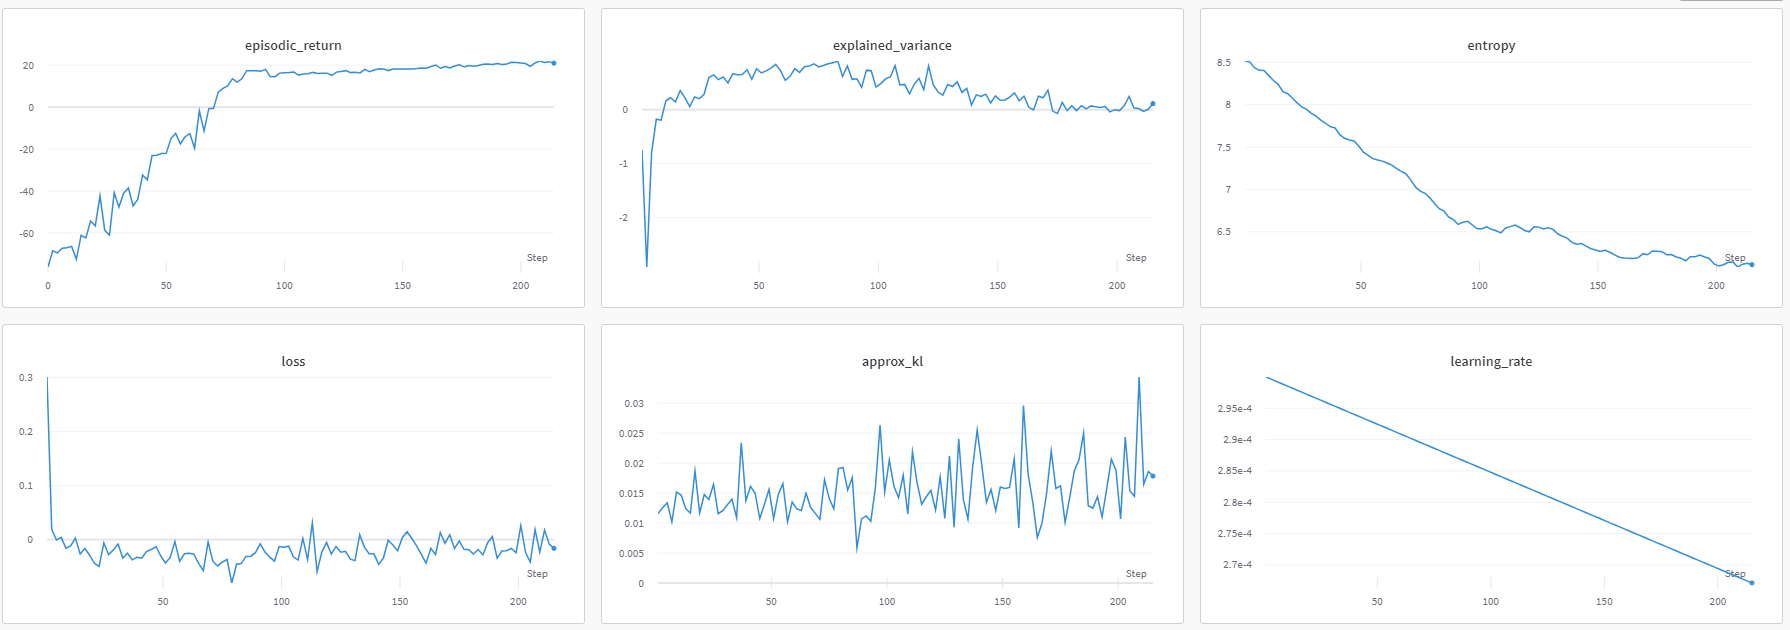

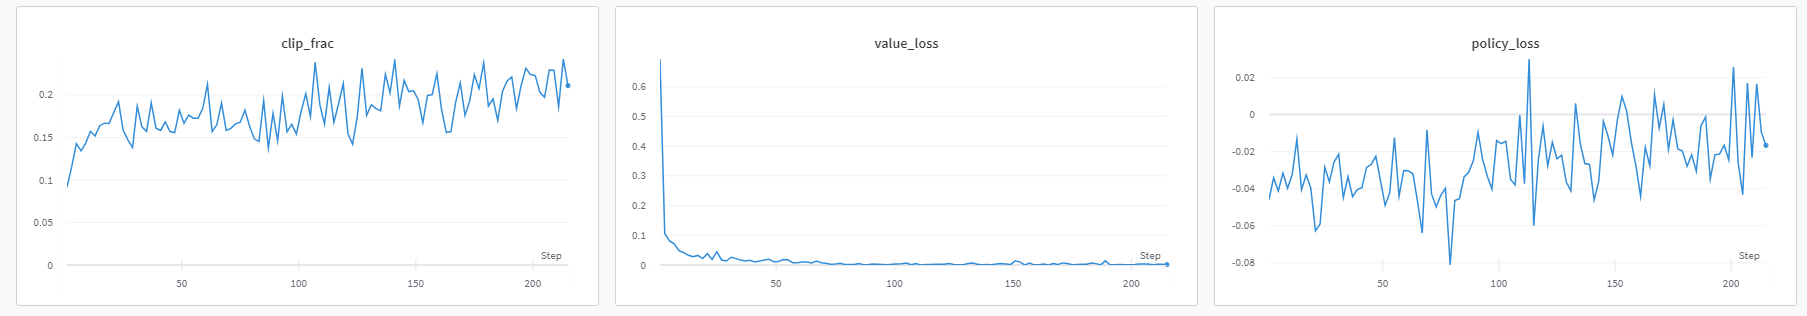

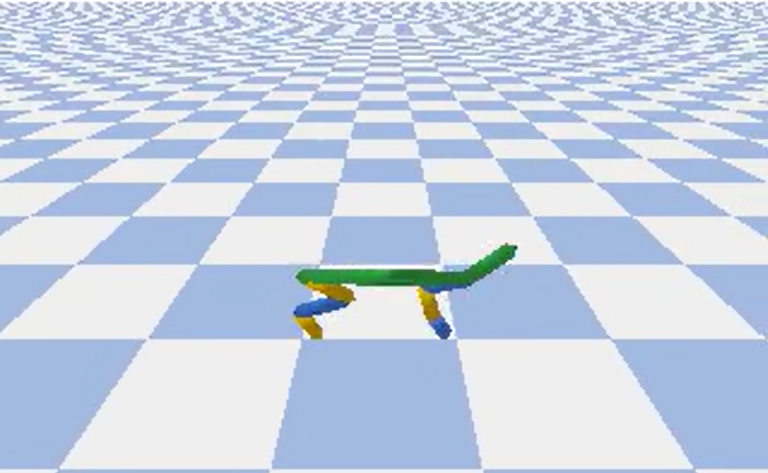